In [75]:
import re
import polars as pl
pl.Config.set_tbl_rows(None)

polars.config.Config

In [76]:
pattern = re.compile(
    r"\[info\] (?:\w+)\.([^\s:]+)(?::([\w\.\-]+))?\s+thrpt\s+\d+\s+(≈?\s*\S+)(?:\s±\s+([\d\.]+))?\s+(\S+)"
)

def unicode_superscript_to_float(s: str) -> float:
    """
    Converts a string like '10⁻⁶' or '≈ 10⁻⁵' into a float (e.g., 1e-6).
    """
    superscripts = {
        '⁰': '0', '¹': '1', '²': '2', '³': '3',
        '⁴': '4', '⁵': '5', '⁶': '6', '⁷': '7', '⁸': '8', '⁹': '9',
        '⁻': '-', '⁺': '+'
    }
    s = s.replace('≈', '').strip()
    if '10' in s:
        base, power = s.split('10')
        exp = ''.join(superscripts.get(ch, '') for ch in power)
        return float(f"1e{exp}")
    return float(s)

# Regex pattern for extracting rows
def parse_jmh(raw_jmh: str) -> pl.DataFrame:
    rows = []
    for m in pattern.finditer(raw_jmh):
        benchmark = m.group(1)
        metric = m.group(2) or "throughput"
        val_str = m.group(3).strip()
        try:
            value = float(val_str.replace("≈", ""))
        except ValueError:
            value = unicode_superscript_to_float(val_str)
        error = float(m.group(4)) if m.group(4) else None
        unit = m.group(5)
        rows.append((benchmark, metric, value, error, unit))


    # Create Polars DataFrame
    df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])
    return df

In [77]:
raw_jmh_prog = """
[info] Benchmark                                                           Mode  Cnt      Score       Error   Units
[info] MatchWithCapsBenchmark.matchAlternationFail                        thrpt   10    113.943 ±     5.490  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate          thrpt   10      3.474 ±     0.172  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate.norm     thrpt   10     32.005 ±     0.001    B/op
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.count               thrpt   10      1.000              counts
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.time                thrpt   10      2.000                  ms
[info] MatchWithCapsBenchmark.matchAlternationHit                         thrpt   10  98126.628 ± 26845.574  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate           thrpt   10   4483.514 ±  1234.408  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate.norm      thrpt   10     48.000 ±     0.001    B/op
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.count                thrpt   10     82.000              counts
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.time                 thrpt   10     54.000                  ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack                     thrpt   10  20876.720 ±  1437.961  ops/ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate       thrpt   10    955.397 ±    66.137  MB/sec
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate.norm  thrpt   10     48.000 ±     0.001    B/op
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.count            thrpt   10     65.000              counts
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.time             thrpt   10     29.000                  ms
[info] MatchWithCapsBenchmark.matchGreedyCapture                          thrpt   10    291.539 ±     7.963  ops/ms
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate            thrpt   10     13.343 ±     0.366  MB/sec
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate.norm       thrpt   10     48.002 ±     0.001    B/op
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.count                 thrpt   10      1.000              counts
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.time                  thrpt   10      2.000                  ms
[info] MatchWithCapsBenchmark.matchManyGroup                              thrpt   10  65286.076 ± 24108.195  ops/ms
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate                thrpt   10   7453.809 ±  2755.917  MB/sec
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate.norm           thrpt   10    120.000 ±     0.001    B/op
[info] MatchWithCapsBenchmark.matchManyGroup:gc.count                     thrpt   10    245.000              counts
[info] MatchWithCapsBenchmark.matchManyGroup:gc.time                      thrpt   10    131.000                  ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral                       thrpt   10   4449.933 ±   364.188  ops/ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate         thrpt   10    203.581 ±    16.779  MB/sec
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate.norm    thrpt   10     48.000 ±     0.001    B/op
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.count              thrpt   10     13.000              counts
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.time               thrpt   10      7.000                  ms
"""

prog_df = parse_jmh(raw_jmh_prog)
print(prog_df)

shape: (30, 5)
┌───────────────────────┬────────────────────┬──────────┬─────────┬────────┐
│ benchmark             ┆ metric             ┆ value    ┆ error   ┆ unit   │
│ ---                   ┆ ---                ┆ ---      ┆ ---     ┆ ---    │
│ str                   ┆ str                ┆ f64      ┆ f64     ┆ str    │
╞═══════════════════════╪════════════════════╪══════════╪═════════╪════════╡
│ matchAlternationFail  ┆ throughput         ┆ 113.943  ┆ 5.49    ┆ ops/ms │
│ matchAlternationFail  ┆ gc.alloc.rate      ┆ 3.474    ┆ 0.172   ┆ MB/sec │
│ matchAlternationFail  ┆ gc.alloc.rate.norm ┆ 32.005   ┆ 0.001   ┆ B/op   │
│ matchAlternationFail  ┆ gc.count           ┆ 1.0      ┆ null    ┆ counts │
│ matchAlternationFail  ┆ gc.time            ┆ 2.0      ┆ null    ┆ ms     │
│ …                     ┆ …                  ┆ …        ┆ …       ┆ …      │
│ matchRepeatingLiteral ┆ throughput         ┆ 4449.933 ┆ 364.188 ┆ ops/ms │
│ matchRepeatingLiteral ┆ gc.alloc.rate      ┆ 203.581  ┆ 16.

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_18890/2346540513.py:38: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])


In [78]:
raw_jmh_cps_callstack = """
[info] Benchmark                                                           Mode  Cnt      Score      Error   Units
[info] MatchWithCapsBenchmark.matchAlternationFail                        thrpt   10    103.057 ±    4.941  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate          thrpt   10      4.713 ±    0.233  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate.norm     thrpt   10     48.005 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.count               thrpt   10      1.000             counts
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.time                thrpt   10      2.000                 ms
[info] MatchWithCapsBenchmark.matchAlternationHit                         thrpt   10  91144.082 ± 5652.734  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate           thrpt   10   5559.147 ±  348.336  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate.norm      thrpt   10     64.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.count                thrpt   10    212.000             counts
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.time                 thrpt   10    112.000                 ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack                     thrpt   10  27253.211 ±  774.632  ops/ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate       thrpt   10   1662.415 ±   47.901  MB/sec
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate.norm  thrpt   10     64.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.count            thrpt   10    112.000             counts
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.time             thrpt   10     43.000                 ms
[info] MatchWithCapsBenchmark.matchGreedyCapture                          thrpt   10    284.896 ±    4.790  ops/ms
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate            thrpt   10     17.377 ±    0.308  MB/sec
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate.norm       thrpt   10     64.002 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.count                 thrpt   10      2.000             counts
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.time                  thrpt   10      3.000                 ms
[info] MatchWithCapsBenchmark.matchManyGroup                              thrpt   10  61183.201 ± 1948.324  ops/ms
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate                thrpt   10   7932.406 ±  254.837  MB/sec
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate.norm           thrpt   10    136.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchManyGroup:gc.count                     thrpt   10    291.000             counts
[info] MatchWithCapsBenchmark.matchManyGroup:gc.time                      thrpt   10    134.000                 ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral                       thrpt   10   4261.659 ±  220.843  ops/ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate         thrpt   10    260.007 ±   13.508  MB/sec
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate.norm    thrpt   10     64.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.count              thrpt   10     18.000             counts
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.time               thrpt   10     10.000                 ms
"""

callstack_cps_df = parse_jmh(raw_jmh_cps_callstack)
print(callstack_cps_df)

shape: (30, 5)
┌───────────────────────┬────────────────────┬──────────┬─────────┬────────┐
│ benchmark             ┆ metric             ┆ value    ┆ error   ┆ unit   │
│ ---                   ┆ ---                ┆ ---      ┆ ---     ┆ ---    │
│ str                   ┆ str                ┆ f64      ┆ f64     ┆ str    │
╞═══════════════════════╪════════════════════╪══════════╪═════════╪════════╡
│ matchAlternationFail  ┆ throughput         ┆ 103.057  ┆ 4.941   ┆ ops/ms │
│ matchAlternationFail  ┆ gc.alloc.rate      ┆ 4.713    ┆ 0.233   ┆ MB/sec │
│ matchAlternationFail  ┆ gc.alloc.rate.norm ┆ 48.005   ┆ 0.001   ┆ B/op   │
│ matchAlternationFail  ┆ gc.count           ┆ 1.0      ┆ null    ┆ counts │
│ matchAlternationFail  ┆ gc.time            ┆ 2.0      ┆ null    ┆ ms     │
│ …                     ┆ …                  ┆ …        ┆ …       ┆ …      │
│ matchRepeatingLiteral ┆ throughput         ┆ 4261.659 ┆ 220.843 ┆ ops/ms │
│ matchRepeatingLiteral ┆ gc.alloc.rate      ┆ 260.007  ┆ 13.

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_18890/2346540513.py:38: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])


In [79]:
raw_jmh_cps_aux_stack = """
[info] Benchmark                                                           Mode  Cnt      Score      Error   Units
[info] MatchWithCapsBenchmark.matchAlternationFail                        thrpt   10     30.727 ±    3.765  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate          thrpt   10   2788.491 ±  342.167  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate.norm     thrpt   10  95192.018 ±    0.003    B/op
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.count               thrpt   10    181.000             counts
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.time                thrpt   10     77.000                 ms
[info] MatchWithCapsBenchmark.matchAlternationHit                         thrpt   10  36804.031 ± 2984.914  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate           thrpt   10   8421.067 ±  684.538  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate.norm      thrpt   10    240.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.count                thrpt   10    275.000             counts
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.time                 thrpt   10    136.000                 ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack                     thrpt   10   3732.288 ±  429.914  ops/ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate       thrpt   10   5664.627 ±  653.476  MB/sec
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate.norm  thrpt   10   1592.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.count            thrpt   10    221.000             counts
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.time             thrpt   10    123.000                 ms
[info] MatchWithCapsBenchmark.matchGreedyCapture                          thrpt   10    242.596 ±   25.373  ops/ms
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate            thrpt   10     55.512 ±    5.811  MB/sec
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate.norm       thrpt   10    240.002 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.count                 thrpt   10      4.000             counts
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.time                  thrpt   10      3.000                 ms
[info] MatchWithCapsBenchmark.matchManyGroup                              thrpt   10   6237.259 ±  573.530  ops/ms
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate                thrpt   10   5280.033 ±  487.031  MB/sec
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate.norm           thrpt   10    888.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchManyGroup:gc.count                     thrpt   10    236.000             counts
[info] MatchWithCapsBenchmark.matchManyGroup:gc.time                      thrpt   10    113.000                 ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral                       thrpt   10    700.661 ±   92.358  ops/ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate         thrpt   10   5444.894 ±  719.872  MB/sec
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate.norm    thrpt   10   8152.001 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.count              thrpt   10    216.000             counts
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.time               thrpt   10    131.000                 ms
"""

aux_stack_cps_df = parse_jmh(raw_jmh_cps_aux_stack)
print(aux_stack_cps_df)

shape: (30, 5)
┌───────────────────────┬────────────────────┬───────────┬─────────┬────────┐
│ benchmark             ┆ metric             ┆ value     ┆ error   ┆ unit   │
│ ---                   ┆ ---                ┆ ---       ┆ ---     ┆ ---    │
│ str                   ┆ str                ┆ f64       ┆ f64     ┆ str    │
╞═══════════════════════╪════════════════════╪═══════════╪═════════╪════════╡
│ matchAlternationFail  ┆ throughput         ┆ 30.727    ┆ 3.765   ┆ ops/ms │
│ matchAlternationFail  ┆ gc.alloc.rate      ┆ 2788.491  ┆ 342.167 ┆ MB/sec │
│ matchAlternationFail  ┆ gc.alloc.rate.norm ┆ 95192.018 ┆ 0.003   ┆ B/op   │
│ matchAlternationFail  ┆ gc.count           ┆ 181.0     ┆ null    ┆ counts │
│ matchAlternationFail  ┆ gc.time            ┆ 77.0      ┆ null    ┆ ms     │
│ …                     ┆ …                  ┆ …         ┆ …       ┆ …      │
│ matchRepeatingLiteral ┆ throughput         ┆ 700.661   ┆ 92.358  ┆ ops/ms │
│ matchRepeatingLiteral ┆ gc.alloc.rate      ┆ 54

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_18890/2346540513.py:38: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])


In [80]:
raw_jmh_javaimpl = """
[info] Benchmark                                                           Mode  Cnt      Score      Error   Units
[info] MatchWithCapsBenchmark.matchAlternationFail                        thrpt   10     26.620 ±    1.210  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate          thrpt   10    528.485 ±   24.741  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.alloc.rate.norm     thrpt   10  20840.033 ±    0.061    B/op
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.count               thrpt   10     35.000             counts
[info] MatchWithCapsBenchmark.matchAlternationFail:gc.time                thrpt   10     16.000                 ms
[info] MatchWithCapsBenchmark.matchAlternationHit                         thrpt   10  34497.323 ±  667.919  ops/ms
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate           thrpt   10   4471.811 ±   89.424  MB/sec
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.alloc.rate.norm      thrpt   10    136.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.count                thrpt   10    195.000             counts
[info] MatchWithCapsBenchmark.matchAlternationHit:gc.time                 thrpt   10     97.000                 ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack                     thrpt   10   3184.827 ±   50.853  ops/ms
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate       thrpt   10   1336.107 ±   21.517  MB/sec
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.alloc.rate.norm  thrpt   10    440.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.count            thrpt   10     90.000             counts
[info] MatchWithCapsBenchmark.matchAmbiguousBacktrack:gc.time             thrpt   10     33.000                 ms
[info] MatchWithCapsBenchmark.matchGreedyCapture                          thrpt   10   4996.667 ±   84.677  ops/ms
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate            thrpt   10    990.729 ±   16.899  MB/sec
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.alloc.rate.norm       thrpt   10    208.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.count                 thrpt   10     67.000             counts
[info] MatchWithCapsBenchmark.matchGreedyCapture:gc.time                  thrpt   10     28.000                 ms
[info] MatchWithCapsBenchmark.matchManyGroup                              thrpt   10  12100.250 ± 1108.585  ops/ms
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate                thrpt   10   2860.774 ±  263.628  MB/sec
[info] MatchWithCapsBenchmark.matchManyGroup:gc.alloc.rate.norm           thrpt   10    248.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchManyGroup:gc.count                     thrpt   10    179.000             counts
[info] MatchWithCapsBenchmark.matchManyGroup:gc.time                      thrpt   10     73.000                 ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral                       thrpt   10   2476.603 ±  154.005  ops/ms
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate         thrpt   10    491.146 ±   30.659  MB/sec
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.alloc.rate.norm    thrpt   10    208.000 ±    0.001    B/op
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.count              thrpt   10     33.000             counts
[info] MatchWithCapsBenchmark.matchRepeatingLiteral:gc.time               thrpt   10     14.000                 ms
"""

javaimpl_df = parse_jmh(raw_jmh_javaimpl)

print(javaimpl_df)

shape: (30, 5)
┌───────────────────────┬────────────────────┬───────────┬─────────┬────────┐
│ benchmark             ┆ metric             ┆ value     ┆ error   ┆ unit   │
│ ---                   ┆ ---                ┆ ---       ┆ ---     ┆ ---    │
│ str                   ┆ str                ┆ f64       ┆ f64     ┆ str    │
╞═══════════════════════╪════════════════════╪═══════════╪═════════╪════════╡
│ matchAlternationFail  ┆ throughput         ┆ 26.62     ┆ 1.21    ┆ ops/ms │
│ matchAlternationFail  ┆ gc.alloc.rate      ┆ 528.485   ┆ 24.741  ┆ MB/sec │
│ matchAlternationFail  ┆ gc.alloc.rate.norm ┆ 20840.033 ┆ 0.061   ┆ B/op   │
│ matchAlternationFail  ┆ gc.count           ┆ 35.0      ┆ null    ┆ counts │
│ matchAlternationFail  ┆ gc.time            ┆ 16.0      ┆ null    ┆ ms     │
│ …                     ┆ …                  ┆ …         ┆ …       ┆ …      │
│ matchRepeatingLiteral ┆ throughput         ┆ 2476.603  ┆ 154.005 ┆ ops/ms │
│ matchRepeatingLiteral ┆ gc.alloc.rate      ┆ 49

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_18890/2346540513.py:38: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])


In [81]:
dfs = {
    "prog": prog_df,
    "cps_callstack": callstack_cps_df,
    "cps_aux_stack": aux_stack_cps_df,
    "javaimpl": javaimpl_df
}

# filter by throughput, concatenate, add source
filtered_dfs = []
for source, df in dfs.items():
    # Filter for throughput metrics
    filtered_df = df.filter(
        pl.col("metric") == "throughput"
    ).filter(
        # exclude GreedyCapture
        ~pl.col("benchmark").str.contains("GreedyCapture")
    )
    
    # Add a new column with the source name
    filtered_df = filtered_df.with_columns(pl.lit(source).alias("source"))
    
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_df)

# Concatenate the filtered DataFrames
combined_df = pl.concat(filtered_dfs)

print(combined_df)

shape: (20, 6)
┌─────────────────────────┬────────────┬───────────┬───────────┬────────┬──────────┐
│ benchmark               ┆ metric     ┆ value     ┆ error     ┆ unit   ┆ source   │
│ ---                     ┆ ---        ┆ ---       ┆ ---       ┆ ---    ┆ ---      │
│ str                     ┆ str        ┆ f64       ┆ f64       ┆ str    ┆ str      │
╞═════════════════════════╪════════════╪═══════════╪═══════════╪════════╪══════════╡
│ matchAlternationFail    ┆ throughput ┆ 113.943   ┆ 5.49      ┆ ops/ms ┆ prog     │
│ matchAlternationHit     ┆ throughput ┆ 98126.628 ┆ 26845.574 ┆ ops/ms ┆ prog     │
│ matchAmbiguousBacktrack ┆ throughput ┆ 20876.72  ┆ 1437.961  ┆ ops/ms ┆ prog     │
│ matchManyGroup          ┆ throughput ┆ 65286.076 ┆ 24108.195 ┆ ops/ms ┆ prog     │
│ matchRepeatingLiteral   ┆ throughput ┆ 4449.933  ┆ 364.188   ┆ ops/ms ┆ prog     │
│ …                       ┆ …          ┆ …         ┆ …         ┆ …      ┆ …        │
│ matchAlternationFail    ┆ throughput ┆ 26.62    

In [82]:
# normalise all values and errors relative to prog
prog_df = combined_df.filter(pl.col("source") == "prog").select(["benchmark", "value", "error"]).rename({"value": "value_prog", "error": "error_prog"})
callstack_cps_df = combined_df.filter(pl.col("source") == "cps_callstack").select(["benchmark", "value", "error"]).rename({"value": "value_cps_callstack", "error": "error_cps_callstack"})
aux_stack_cps_df = combined_df.filter(pl.col("source") == "cps_aux_stack").select(["benchmark", "value", "error"]).rename({"value": "value_cps_aux_stack", "error": "error_cps_aux_stack"})
javaimpl_df = combined_df.filter(pl.col("source") == "javaimpl").select(["benchmark", "value", "error"]).rename({"value": "value_javaimpl", "error": "error_javaimpl"})
# Join the DataFrames on the benchmark column
normalised_df = prog_df.join(
        callstack_cps_df, on="benchmark", how="inner"
    ).join(
        aux_stack_cps_df, on="benchmark", how="inner"
    ).join(
        javaimpl_df, on="benchmark", how="inner"
    )
# Calculate the relative values and errors
normalised_df = normalised_df.with_columns(
    (pl.col("value_cps_callstack") / pl.col("value_prog")).alias("value_cps_callstack_rel"),
    (pl.col("error_cps_callstack") / pl.col("value_prog")).alias("error_cps_callstack_rel"),
    (pl.col("value_cps_aux_stack") / pl.col("value_prog")).alias("value_cps_aux_stack_rel"),
    (pl.col("error_cps_aux_stack") / pl.col("value_prog")).alias("error_cps_aux_stack_rel"),
    (pl.col("value_javaimpl") / pl.col("value_prog")).alias("value_javaimpl_rel"),
    (pl.col("error_javaimpl") / pl.col("value_prog")).alias("error_javaimpl_rel")
)
# Print the final DataFrame
print(normalised_df)


shape: (5, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ benchmark ┆ value_pro ┆ error_pro ┆ value_cps ┆ … ┆ value_cps ┆ error_cps ┆ value_jav ┆ error_ja │
│ ---       ┆ g         ┆ g         ┆ _callstac ┆   ┆ _aux_stac ┆ _aux_stac ┆ aimpl_rel ┆ vaimpl_r │
│ str       ┆ ---       ┆ ---       ┆ k         ┆   ┆ k_rel     ┆ k_rel     ┆ ---       ┆ el       │
│           ┆ f64       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ matchAlte ┆ 113.943   ┆ 5.49      ┆ 103.057   ┆ … ┆ 0.26967   ┆ 0.033043  ┆ 0.233626  ┆ 0.010619 │
│ rnationFa ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ il        ┆           ┆           ┆           ┆   ┆           ┆           

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_18890/696954378.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


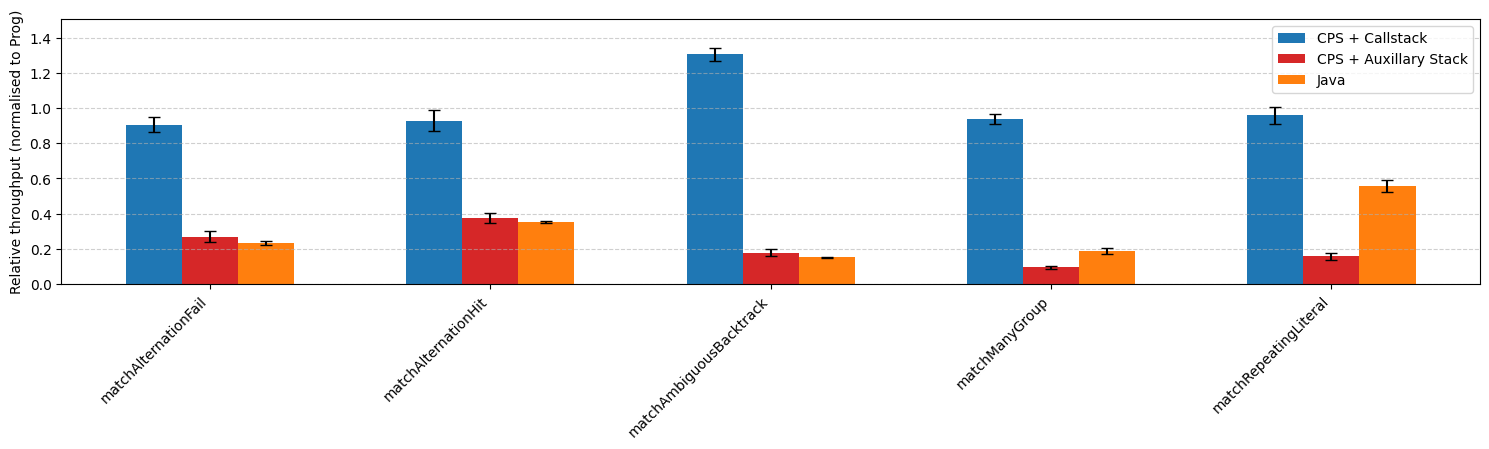

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

# Assume your DataFrame is ready
df = normalised_df  # or whatever your actual DataFrame is

# Plot config
benchmarks = df["benchmark"].to_list()
x = np.arange(len(benchmarks))
width = 0.2

# Extract values
cps_callstack = df["value_cps_callstack_rel"].to_numpy()
cps_callstack_err = df["error_cps_callstack_rel"].to_numpy()
cps_aux_stack = df["value_cps_aux_stack_rel"].to_numpy()
cps_aux_stack_err = df["error_cps_aux_stack_rel"].to_numpy()
java = df["value_javaimpl_rel"].to_numpy()
java_err = df["error_javaimpl_rel"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(15, 4.5))  # Wider, flatter aspect
bars1 = ax.bar(x - width, cps_callstack, width, yerr=cps_callstack_err, capsize=4, label="CPS + Callstack", color="tab:blue")
bars2 = ax.bar(x, cps_aux_stack, width, yerr=cps_aux_stack_err, capsize=4, label="CPS + Auxillary Stack", color="tab:red")
bars3 = ax.bar(x + width, java, width, yerr=java_err, capsize=4, label="Java", color="tab:orange")

# Labels, legend
ax.set_ylabel("Relative throughput (normalised to Prog)")
ax.set_xticks(x)
ax.set_xticklabels(benchmarks, rotation=45, ha="right")
ax.set_ylim(0, max(java.max() + java_err.max(), cps_callstack.max(), cps_callstack_err.max(), cps_aux_stack.max() + cps_aux_stack_err.max()) + 0.2)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout before export
fig.tight_layout()

# Save to TikZ/PGFPlots
tikzplotlib.save("relative_throughput_caps_plot.tex")
fig.show()


In [84]:
# do something similar for gc.alloc.rate.norm
print(combined_df)


shape: (20, 6)
┌─────────────────────────┬────────────┬───────────┬───────────┬────────┬──────────┐
│ benchmark               ┆ metric     ┆ value     ┆ error     ┆ unit   ┆ source   │
│ ---                     ┆ ---        ┆ ---       ┆ ---       ┆ ---    ┆ ---      │
│ str                     ┆ str        ┆ f64       ┆ f64       ┆ str    ┆ str      │
╞═════════════════════════╪════════════╪═══════════╪═══════════╪════════╪══════════╡
│ matchAlternationFail    ┆ throughput ┆ 113.943   ┆ 5.49      ┆ ops/ms ┆ prog     │
│ matchAlternationHit     ┆ throughput ┆ 98126.628 ┆ 26845.574 ┆ ops/ms ┆ prog     │
│ matchAmbiguousBacktrack ┆ throughput ┆ 20876.72  ┆ 1437.961  ┆ ops/ms ┆ prog     │
│ matchManyGroup          ┆ throughput ┆ 65286.076 ┆ 24108.195 ┆ ops/ms ┆ prog     │
│ matchRepeatingLiteral   ┆ throughput ┆ 4449.933  ┆ 364.188   ┆ ops/ms ┆ prog     │
│ …                       ┆ …          ┆ …         ┆ …         ┆ …      ┆ …        │
│ matchAlternationFail    ┆ throughput ┆ 26.62    

In [85]:
metric = "gc.alloc.rate.norm"
filtered = {}

for name, df in dfs.items():
    filtered[name] = (
        df.filter(pl.col("metric") == metric)
          .select(["benchmark", "value", "error"])
          .rename({"value": f"value_{name}", "error": f"error_{name}"})
    )

# Join all filtered DataFrames on 'benchmark'
merged = filtered["prog"]
for name in ["cps", "javaimpl"]:
    merged = merged.join(filtered[name], on="benchmark")

# Convert to pandas for plotting
benchmarks = merged["benchmark"].to_list()
x = np.arange(len(benchmarks))
width = 0.25

# Values and error bars
vals_prog = merged["value_prog"].to_numpy()
err_prog = merged["error_prog"].to_numpy()
vals_cps = merged["value_cps"].to_numpy()
err_cps = merged["error_cps"].to_numpy()
vals_java = merged["value_javaimpl"].to_numpy()
err_java = merged["error_javaimpl"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, vals_prog, width, yerr=err_prog, label="Prog", capsize=4, color="tab:green")
ax.bar(x, vals_cps, width, yerr=err_cps, label="CPS", capsize=4, color="tab:blue")
ax.bar(x + width, vals_java, width, yerr=err_java, label="Java", capsize=4, color="tab:orange")

# Labels
ax.set_xticks(x)
ax.set_xticklabels(benchmarks, rotation=45, ha="right")
ax.set_yscale("log")
ax.set_ylabel("Bytes allocated per instruction (B/op)")
ax.set_title("log bytes allocation per instruction (B/op)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
tikzplotlib.save("gc_alloc_rate_norm_plot.tex")


KeyError: 'cps'